In [1]:
import torch
import pandas as pd
import numpy as np
import sys 
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
sys.path.append("./")
from prediction.api import *
from prediction.data_wrapper import get_loaders
from pickle import dump

In [2]:
args.data = './data/processed/processed_cleaned_df.csv'
args.input_size = [33]
args.hidden_size = 300
args.number_of_layers = 10
args.output_size = [1]
args.test_portion = 0.2 
args.train_window = 12
args.batch_size = 64
args.learning_rate = 0.001
args.weight_decay = 0.0001
args.gpu = 0 
args.epochs = 100
args.log_freq = 30
args.debug = False
args.seed = 1
args.samples = 20
args.dropout = 0.3

In [3]:
model, scaler = get_model()
print(model)

Network(
  (lstm): LSTM(33, 300, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)


In [4]:
df = pd.read_csv(args.data).iloc[:,1:]

print(df.head())

GPs  month      07    0304  050103  131002     2101   010305       01  \
0  A81001      1  7271.0  4071.0  1476.0   185.0  4964.00  13032.0  69503.0   
1  A81001      2  8527.0  4071.0  1427.0   191.0  3841.00  12740.0  78753.0   
2  A81001      3  6402.0  3928.0  1278.0   198.0  4188.25  11574.0  65473.0   
3  A81001      4  7295.0  4836.0  1537.0   231.0  4535.50  13019.0  74436.0   
4  A81001      5  6671.0  5153.0  1436.0   280.0  4882.75  11824.0  65084.0   

       05  ...  030401       13           12     0106     1302       10  \
0  9767.0  ...  4310.0  59472.0   886.000000  19797.0  49930.0  15657.0   
1  9767.0  ...  4064.0  59472.0   994.666667  24304.0  49930.0  12903.0   
2  9767.0  ...  3928.0  59472.0  1103.333333  20416.0  44955.0  13236.0   
3  9767.0  ...  4836.0  58722.0  1212.000000  24713.0  45005.0  14082.0   
4  9767.0  ...  5152.0  57972.0   817.000000  20309.0  42955.0  12972.0   

    130201  050108    0603   010604  
0  41880.0   998.0  4034.0  10939.0  
1  4

In [5]:
data = df.to_numpy()
gps = data[:,0]
features = data[:,1:]
label_index = df.columns.get_loc('0301')

In [6]:
print(features.shape, gps.shape)

(398518, 33) (398518,)


In [7]:
total_size = len(features)
train_size = int((1-args.test_portion) * total_size)

test_data = features[train_size:]

test_gps = gps[train_size:]

test_unique_gps = np.unique(test_gps)
test_data_normalized = scaler.transform(test_data)
test_data_normalized = torch.FloatTensor(test_data_normalized)

In [8]:
def create_inout_sequences(input_data,_gps,_unique_gps,_label_index, tw):
    X = []
    Y = []
    for i in tqdm(range(len(_unique_gps))):
        for j in range(len(_gps[_gps == _unique_gps[i]]) - tw):
            seq = input_data[j:j+tw]
            label = input_data[j+tw:j+tw+1,_label_index]
            seq = np.array(seq, dtype=np.float32)
            label = np.array(label, dtype = np.float32)
            X.append(torch.from_numpy(seq).float())
            Y.append(torch.from_numpy(label).float())

    return X, Y
X_test, Y_test = create_inout_sequences(test_data_normalized, test_gps, test_unique_gps, label_index, args.train_window)

100%|██████████| 1375/1375 [00:03<00:00, 396.61it/s]


In [9]:
X_test = torch.stack(X_test)
Y_test = torch.stack(Y_test)
print(X_test.shape, Y_test.shape)

torch.Size([63204, 12, 33]) torch.Size([63204, 1])


[83.99967586994194, 209.84997159242653, 305.056604921818, 506.67769089341186, 158.5914684236052, 261.50857049226784, 442.8209439814093, 532.7595278322699, 499.7417193949225, 331.8336540758612, 288.022070348263, 287.7086008489134, 368.06984725594543, 625.9612777829173, 258.1888771057131, 283.15852132439636, 494.1902993619444, 522.2865632474425, 457.40938869118713, 488.6594347059729, 395.8761335015299, 377.45851570367836, 230.37231317162536, 253.6865154206755, 472.85528627038025, 587.9815481603148, 241.41715770959877, 392.16515383124374, 604.6328717768195, 768.7763666212561, 675.6876712441447, 526.6538467407229, 367.5647722780707, 423.79841080307983, 361.36732611060165, 355.39672321081184, 573.0994552075865, 716.7991593778136, 293.71590977907204, 323.3009702563288, 613.8064428865912, 781.2270521223547, 661.7224949300291, 526.4908719658854, 423.38583502173447, 449.34360557794594] [83.99967586994194, 454.00013259053253, 420.0000707805159, 390.0002321600916, 414.9999753236773, 381.999785780

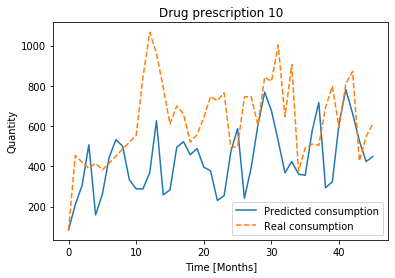

In [10]:

outs = []
scaled_outs = []
golden_outs = []
buffer = []
feature_vector = X_test[0,:]
with torch.no_grad():
    for i in range(0,46):
        ys = []
        for sample in range(args.samples):
            y = model(feature_vector.unsqueeze(dim=0))
            ys.append(y)
        ys = torch.stack(ys)
        outs.append(torch.mean(ys).item())
        feature_vector = X_test[i]
        golden_outs.append(scaler.inverse_transform(feature_vector[-1].view(1,-1)).reshape(-1)[label_index])
        c = 1
        while c<=12 and c<len(outs):
            feature_vector[-c, label_index] = outs[-c]
            c+=1

        scaled_outs.append(scaler.inverse_transform(feature_vector[-1].view(1,-1)).reshape(-1)[label_index])
plt.plot(scaled_outs, label="Predicted consumption")
plt.plot(golden_outs, '--', label ="Real consumption")

plt.legend()
plt.xlabel("Time [Months]")
plt.ylabel("Quantity")
plt.title("Drug prescription {}".format(label_index))
print(scaled_outs, golden_outs)